In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load mm object from the file
filename = "morphmodel.pkl"
with open(filename, "rb") as file:
    mm = pickle.load(file)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import trange

In [3]:
datamatrix = mm.datamatrix.reshape(mm.datamatrix.shape[0], 3, 64, 64)

In [73]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = mm.datamatrix.reshape(12484, 3, 64, 64)
data = data[:, 0, :]  # Use only the first map to learn the model


targets = mm.scores
targets = datamatrix




# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=42)

# Assuming you have your training data and targets as tensors
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Convert test data and targets into a TensorDataset

# Convert training data and targets into a TensorDataset
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)


# Define the batch size for training
batch_size = 64



# Create the train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [46]:
def get_dataindex(img):
    index  = np.where(np.all(data == img, axis=1))[0][0]
    return index
def plot_results(index, test_input, reconstructed_images, rec_scores,save_name = None, return_scores = False, show = True):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    groundtruth = test_input[index].cpu().reshape(64, 64)
    datindx = get_dataindex(groundtruth.numpy())

    truth_scores = mm.scores[datindx]
    age_truth = datamatrix[datindx, 1]
    mass_truth = datamatrix[datindx, 2]


    metal_rec = reconstructed_images[index,0].reshape(64, 64)
    age_rec = reconstructed_images[index,1].reshape(64, 64)
    mass_rec = reconstructed_images[index,2].reshape(64, 64)

    res_metal = np.abs(groundtruth - metal_rec)#/ np.abs(groundtruth) *100
    res_age = np.abs(age_truth - age_rec)#/ np.abs(age_truth) *100
    res_mass = np.abs(mass_truth - mass_rec)#/ np.abs(mass_truth) *100

    ax[0, 0].imshow(groundtruth)
    ax[0, 0].set_title(f"Groundtruth: Metallicity")

    ax[0, 1].imshow(metal_rec)
    ax[0, 1].set_title(f"Reconstructed: Metallicity")

    ax[0, 2].imshow(res_metal)
    ax[0, 2].set_title(f"Difference: Metallicity")

    ax[1, 0].imshow(age_truth)
    ax[1, 0].set_title(f"Groundtruth: Age")

    ax[1, 1].imshow(age_rec)
    ax[1, 1].set_title(f"Reconstructed: Age")

    ax[1, 2].imshow(res_age)
    ax[1, 2].set_title(f"Difference: Age")

    ax[2, 0].imshow(mass_truth)
    ax[2, 0].set_title(f"Groundtruth: Mass")

    ax[2, 1].imshow(mass_rec)
    ax[2, 1].set_title(f"Reconstructed: Mass")

    ax[2, 2].imshow(res_mass)
    ax[2, 2].set_title(f"Difference: Mass")

    fig.suptitle(f"Difference between groundtruth and reconstructed images: GalaxyIndex {datindx}")
    
    difference_scores = truth_scores - rec_scores[index].cpu().detach().numpy()
    
    if save_name is not None:
        fig.savefig(f"results/{save_name}")

    
    if show:plt.show()
    if return_scores: return(difference_scores, truth_scores, rec_scores[index])


In [82]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, number_of_maps, latent_dim, img_channels=1):
        super(ConvolutionalVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, number_of_maps, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, z

# Define the neural network architecture
class VAE(nn.Module):
    def __init__(self, img_size,number_of_maps, latent_dim, eigengalaxies, means, mapindex):
        super(VAE, self).__init__()
        
        # Encoder layers
        #self.encoder_fc1 = nn.Linear(img_size, 512)
        #self.encoder_fc2 = nn.Linear(512, 256)
        #self.encoder_fc3 = nn.Linear(256, 128)
        #self.encoder_fc4 = nn.Linear(128, latent_dim)
        
        
        self.encoder_fc1 = nn.Linear(img_size, 1024)
        self.encoder_fc2 = nn.Linear(1024, 256)
        self.encoder_fc3 = nn.Linear(256, 128)
        self.encoder_fc4 = nn.Linear(128, latent_dim)
        
    
        self.linear_60 = nn.Linear(60, 60)
        
        
        
        self.latent_dim = latent_dim
        self.eigengalaxies = eigengalaxies
        self.means = means # Means of the calculated PCA
        self.number_of_maps = number_of_maps
        self.img_size = img_size
        self.mapindex = mapindex
        # Dropout layer
        self.dropout = nn.Dropout(0.2)

    def encode(self, x):
        x = x- self.means[self.mapindex]
        x = torch.flatten(x, start_dim=1)
        # Proejct images to eigengalaxies of specific map
        #mapeigen = self.eigengalaxies[:,self.mapindex]
        #mapeigen = torch.flatten(mapeigen, start_dim=1)
       
        #x = torch.matmul(x, mapeigen.t()) # 60 scores components
        x = torch.relu(self.encoder_fc1(x))
        #x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.encoder_fc2(x))
        #x = self.dropout(x)  # Apply dropout
        x = self.encoder_fc3(x)
        #x = self.dropout(x)  # Apply dropout
        z = self.encoder_fc4(x) 
        return z
    def decode(self, z):
        #z are the scores components
        # Reconstruct images from scores components
        # Eigengalaxies are shape (num_eigengalaxies, number_of_maps, img_size)
        eigengalaxies = self.eigengalaxies.view(self.latent_dim, self.number_of_maps*self.img_size)
        means = self.means.view(self.number_of_maps*img_size)
        x = torch.matmul(z, eigengalaxies) + means
        x = x.view(-1, number_of_maps, 64, 64)
        return x
        x = torch.relu(self.decoder_fc1(z))
        x = torch.relu(self.decoder_fc2(x))
        x = self.decoder_fc3(x)
        x = torch.sigmoid(x)
        x = x.view(-1, 1, 64, 64)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x, z


img_size = 64 * 64
number_of_maps = 3 #Metallicity, AGE, MASSES
num_eigengalaxies = 60
latent_dim = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

means = mm.get_means()
eigengalaxies = mm.get_eigengalaxies()

means = torch.Tensor(means).to(device)
eigengalaxies = torch.Tensor(eigengalaxies).to(device)
mapindex = 0

model = VAE(img_size=img_size, latent_dim=latent_dim, 
                number_of_maps=number_of_maps, eigengalaxies=eigengalaxies, means=means, mapindex=mapindex).to(device)


model = ConvolutionalVAE(number_of_maps=number_of_maps, latent_dim=latent_dim)

criterion = nn.MSELoss().to(device)  # Use mean squared error as the loss function
#criterion = nn.L1Loss().to(device)  
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Choose an optimizer

model.train()  # Set the model to training mode
# Step 5: Train the network

log_file = "loss_log.txt"

train_loss = []
test_loss = []
#clear the log file
with open(log_file, "w") as f:
    f.write("Starting training...\n")


num_epochs = 2000
lambda_reg = 0.001
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True, factor = 0.1)
# Remove files in the results folder
import os
import glob 
files = glob.glob('results/*.png')
[os.remove(f) for f in files]
for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs,targets in train_loader:
       
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        
        reconstructed_images, z = model(inputs)
        
        #metall_img = reconstructed_images[:,0]
        
         # Calculate the MSE loss between metall_img and inputs
        #loss_reconstruction = criterion(metall_img, inputs)
        
        loss_reconstruction = criterion(reconstructed_images, targets)
        # Calculate the MSE loss between z and the target scores
        #loss_z = criterion(z, targets)
        
        l1_regularization = torch.tensor(0.).to(device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)
            
        #loss = loss_reconstruction +10* loss_z + lambda_reg * l1_regularization
        loss = loss_reconstruction
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch % 10 == 0:
        with torch.no_grad():
            model.eval()
            test_loss_this_epoch = 0.0
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                reconstructed_images, z = model(inputs)
                #metall_img = reconstructed_images[:,0]
                
                #loss_reconstruction = criterion(metall_img, inputs)
                loss_reconstruction = criterion(reconstructed_images, targets)
                #loss_z = criterion(z, targets)
                #loss = loss_reconstruction + loss_z
                loss = loss_reconstruction
                test_loss_this_epoch += loss.item()
            average_test_loss = test_loss_this_epoch / len(test_loader)
            test_loss.append(average_test_loss)
            scheduler.step(average_test_loss)
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch+1}/{num_epochs}, Mean Train Loss: {average_loss}\n")
                f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")
            if epoch % 50 == 0:  
                plot_results(0,inputs, reconstructed_images.cpu().numpy(),z,save_name=f"results_{epoch}.png",return_scores=False,show=False) 
                plt.close("all")
            model.train()
       


  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 1, 4, 4], expected input[1, 64, 64, 64] to have 1 channels, but got 64 channels instead

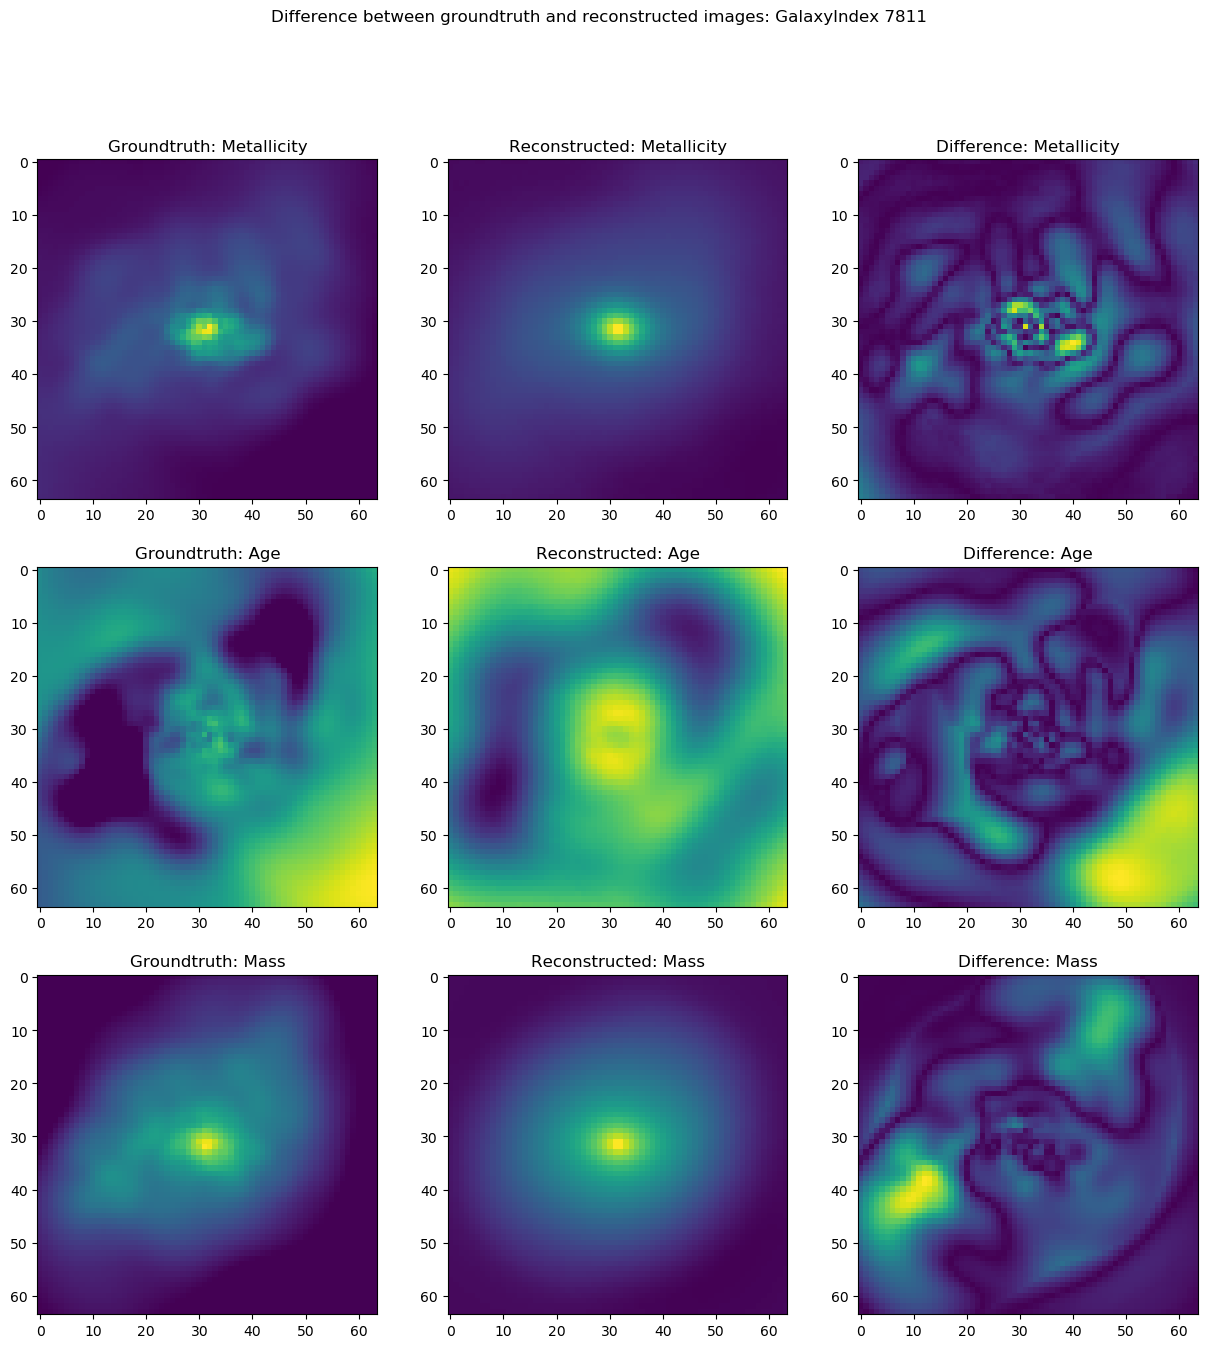

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  6., 41.,  5.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.97653138e+03, -1.79618459e+03, -1.61583781e+03, -1.43549103e+03,
        -1.25514425e+03, -1.07479746e+03, -8.94450679e+02, -7.14103896e+02,
        -5.33757113e+02, -3.53410330e+02, -1.73063548e+02,  7.28323538e+00,
         1.87630018e+02,  3.67976801e+02,  5.48323584e+02,  7.28670367e+02,
         9.09017150e+02,  1.08936393e+03,  1.26971072e+03,  1.45005750e+03,
         1.63040428e+03,  1.81075106e+03,  1.99109785e+03,  2.17144463e+03,
         2.35179141e+03,  2.53213820e+03,  2.71248498e+03,  2.89283176e+03,
         3.07317855e+03,  3.25352533e+03,  3.43387211e+03,  3.61421889e+03,
         3.79456568e+03,  3.97491246e+03,  4.15525

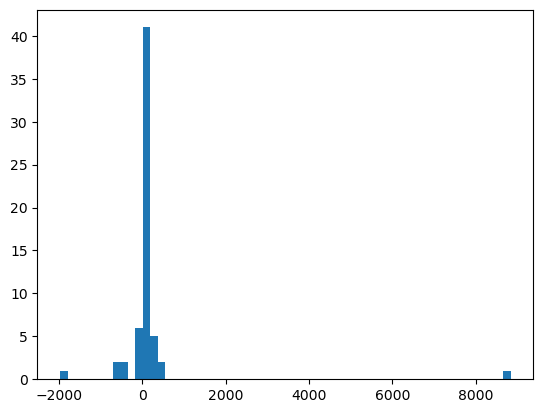

In [68]:
batch = 0
index = 16
plot = True
model.eval()  # Set the model to evaluation mode
# Step 6: Test the network
import os 
os.makedirs("results", exist_ok=True)

reconstructed_images= []
with torch.no_grad():
    for test_input in test_loader:
        test_input = next(iter(test_loader))[batch].to(device)
        reconstructed_images, scores = model(test_input)
        reconstructed_images = reconstructed_images.cpu().numpy()  # Convert tensors to numpy arrays    

diff_scores, true_scores, rec_scores = plot_results(index, test_input, reconstructed_images, scores, return_scores = True)

deviation=diff_scores/true_scores * 100
plt.hist(deviation, bins=60)


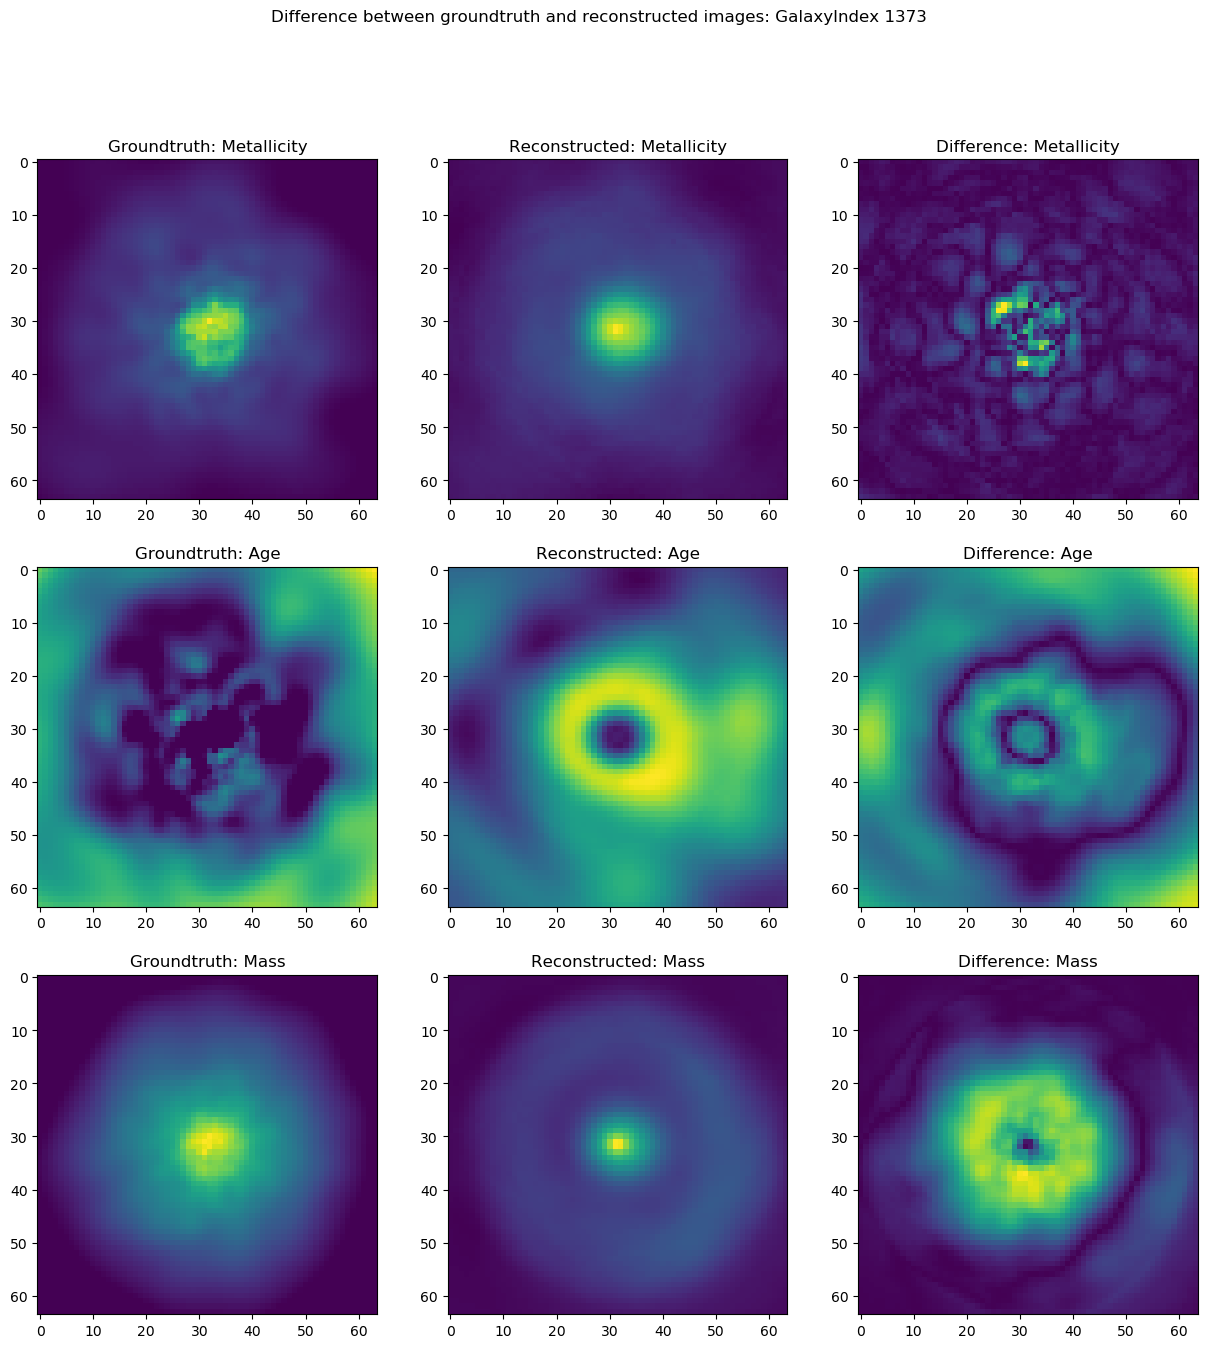

(array([1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 2., 1., 2., 1., 0.,
        1., 1., 6., 4., 9., 7., 4., 5., 1., 1., 1., 0., 1., 3., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([-2955.22945136, -2821.23825006, -2687.24704876, -2553.25584746,
        -2419.26464616, -2285.27344486, -2151.28224356, -2017.29104225,
        -1883.29984095, -1749.30863965, -1615.31743835, -1481.32623705,
        -1347.33503575, -1213.34383445, -1079.35263315,  -945.36143185,
         -811.37023055,  -677.37902924,  -543.38782794,  -409.39662664,
         -275.40542534,  -141.41422404,    -7.42302274,   126.56817856,
          260.55937986,   394.55058116,   528.54178246,   662.53298377,
          796.52418507,   930.51538637,  1064.50658767,  1198.49778897,
         1332.48899027,  1466.48019157,  1600.47139287,  1734.46259417,
         1868.45379547,  2002.44499677,  2136.43619808,  2270.42739938,
      

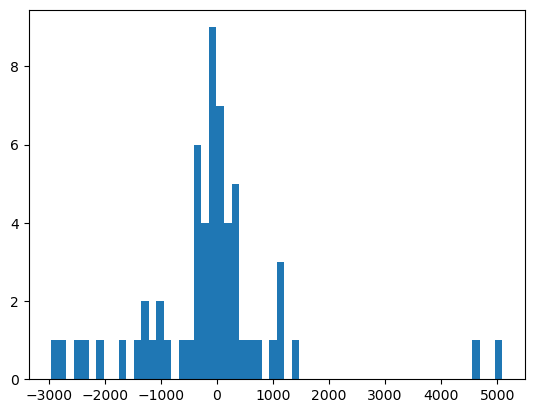

In [ ]:
batch = 0
index = 50
plot = True
model.eval()  # Set the model to evaluation mode
# Step 6: Test the network
reconstructed_images= []
with torch.no_grad():
    for test_input in test_loader:
        test_input = next(iter(test_loader))[batch].to(device)
        reconstructed_images, scores = model(test_input)
        reconstructed_images = reconstructed_images.cpu().numpy()  # Convert tensors to numpy arrays    

diff_scores, true_scores, rec_scores = plot_results(index, test_input, reconstructed_images, scores)

deviation=diff_scores/true_scores * 100
plt.hist(deviation, bins=60)


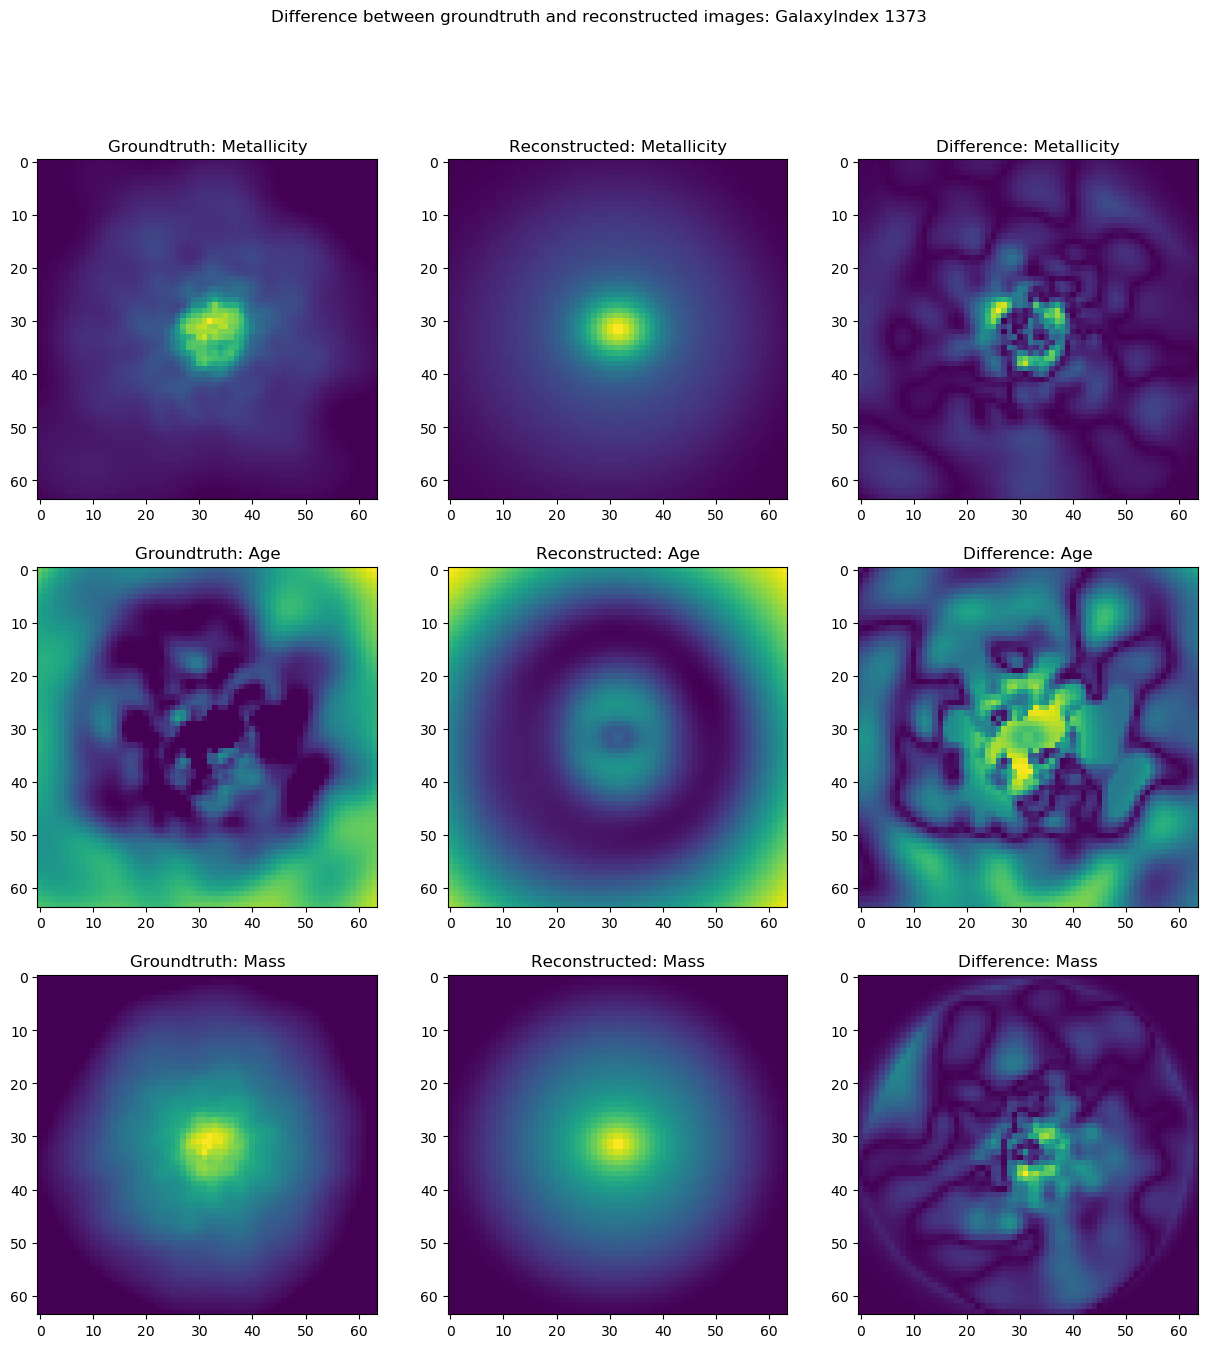

(array([ 1.,  0.,  2.,  0.,  0.,  7., 15., 19.,  7.,  2.,  2.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-107.72667458,  -79.98961667,  -52.25255876,  -24.51550086,
           3.22155705,   30.95861495,   58.69567286,   86.43273076,
         114.16978867,  141.90684658,  169.64390448,  197.38096239,
         225.11802029,  252.8550782 ,  280.5921361 ,  308.32919401,
         336.06625192,  363.80330982,  391.54036773,  419.27742563,
         447.01448354,  474.75154144,  502.48859935,  530.22565726,
         557.96271516,  585.69977307,  613.43683097,  641.17388888,
         668.91094678,  696.64800469,  724.3850626 ,  752.1221205 ,
         779.85917841,  807.59623631,  835.33329422,  863.07035213,
         890.80741003,  918.54446794,  946.281

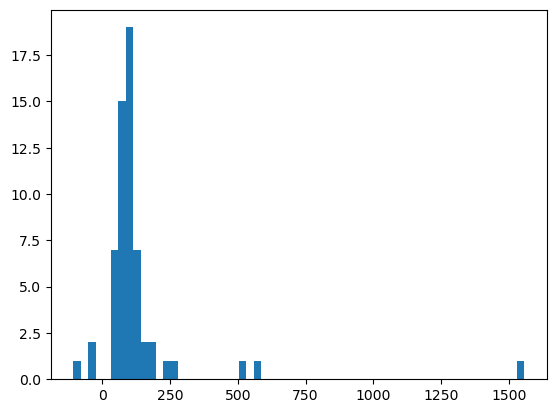

In [202]:
batch = 0
index = 50
plot = True
model.eval()  # Set the model to evaluation mode
# Step 6: Test the network
reconstructed_images= []
with torch.no_grad():
    for test_input in test_loader:
        test_input = next(iter(test_loader))[batch].to(device)
        reconstructed_images, scores = model(test_input)
        reconstructed_images = reconstructed_images.cpu().numpy()  # Convert tensors to numpy arrays    

diff_scores, true_scores, rec_scores = plot_results(index, test_input, reconstructed_images, scores)

deviation=diff_scores/true_scores * 100
plt.hist(deviation, bins=60)


array([ 6.95436186e+02, -6.45184512e+01, -3.94949093e+02, -8.90206953e+02,
        3.04946733e+02, -2.15861256e+02, -7.46844362e+01, -1.24811934e+03,
       -2.78199310e+02,  1.64708512e+02,  2.58198050e+02, -2.02446241e+03,
       -1.70934961e+03,  1.07250253e+03, -1.06499024e+02, -2.05143922e+02,
        5.95254665e+02,  4.94371306e+01, -2.99734774e+02, -9.48778322e+02,
        5.08424263e+03, -2.74351795e+03,  9.50606945e+01,  4.62064494e+03,
       -2.69188350e+02,  3.59311698e+02, -1.12549491e+03, -2.35142309e+03,
        3.58223716e+02, -1.30331416e+02,  2.89224191e+02,  1.09060194e+00,
       -1.00396055e+03,  4.20649116e+01,  1.09407729e+03,  7.52161562e+01,
       -1.36966825e+03,  1.46106111e+02, -1.30937877e+03, -6.13715958e+02,
        5.17644657e+02, -3.83900712e+02,  3.14711055e+00, -2.95522945e+03,
        1.10390088e+03,  1.12195115e+02, -5.35642318e+01, -3.45370323e+02,
       -3.70115850e+01, -2.86577662e+02, -1.14104644e+01,  1.41991436e+03,
        2.30843084e+02, -

(array([1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 2., 1., 2., 1., 0.,
        1., 1., 6., 4., 9., 7., 4., 5., 1., 1., 1., 0., 1., 3., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([-29.55229451, -28.2123825 , -26.87247049, -25.53255847,
        -24.19264646, -22.85273445, -21.51282244, -20.17291042,
        -18.83299841, -17.4930864 , -16.15317438, -14.81326237,
        -13.47335036, -12.13343834, -10.79352633,  -9.45361432,
         -8.11370231,  -6.77379029,  -5.43387828,  -4.09396627,
         -2.75405425,  -1.41414224,  -0.07423023,   1.26568179,
          2.6055938 ,   3.94550581,   5.28541782,   6.62532984,
          7.96524185,   9.30515386,  10.64506588,  11.98497789,
         13.3248899 ,  14.66480192,  16.00471393,  17.34462594,
         18.68453795,  20.02444997,  21.36436198,  22.70427399,
         24.04418601,  25.38409802,  26.72401003,  28.06392205,
         29.40383406, 

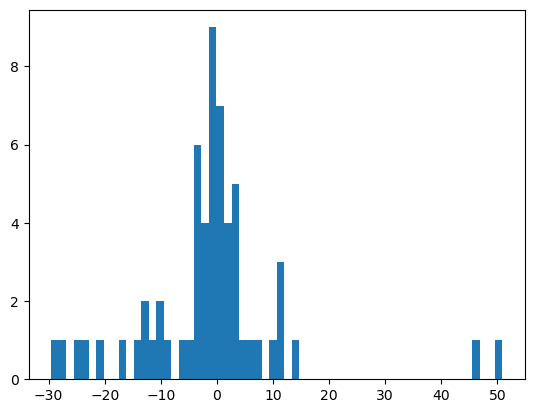

(60,)

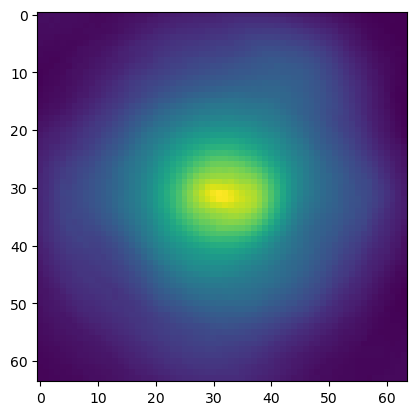

In [32]:
def evaluate_prediction(model, index,batch = 0,plot = True):
    model.eval()  # Set the model to evaluation mode
    # Step 6: Test the network
    reconstructed_images= []
    with torch.no_grad():
        for test_input in test_loader:
            test_input = next(iter(test_loader))[batch].to(device)
            reconstructed_images, scores = model(test_input)
            reconstructed_images = reconstructed_images.cpu().numpy()  # Convert tensors to numpy arrays    
    
    reconstructed_images_pred = reconstructed_images[index]
    reconstructed_images_target = mm.reconstruct(target_score)
    # Make residual plots for all 3 maps
    # Calculate residuals for each map
    residuals = np.abs(reconstructed_images_pred - reconstructed_images_target) / reconstructed_images_target * 100

    reconstruction_error = np.median(residuals)
    if not plot: return reconstruction_error
    # Plot the original images, reconstructed images, and residuals
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    # Iterate over the maps
    for i in range(3):
        # Plot original image
        axes[i, 0].imshow(reconstructed_images_target[i])
        axes[i, 0].set_title(f"Ground Truth Map {i+1}")
        # Plot reconstructed image from predicted scores
        axes[i, 1].imshow(reconstructed_images_pred[i])
        axes[i, 1].set_title(f"Reconstructed (Predicted) Map {i+1}")

        axes[i,2].imshow(residuals[i], cmap = "coolwarm",vmin=-100, vmax=100)
        axes[i, 2].set_title(f"Residual {i+1}")

        
        

        # Set axis labels
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()
    return reconstruction_error

In [ ]:

# Step 7: Generate images from scores components
with torch.no_grad():
    test_scores = load_new_scores_data()  # Load scores components for generating images
    test_scores = torch.Tensor(test_scores).to(device)
    
    generated_images = model.decode(test_scores)
    generated_images = generated_images.cpu().numpy()  # Convert tensors to numpy arrays
    
    # Visualize the generated images
